In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *


Using TensorFlow backend.


In [ ]:
# using the FER2013 dataset from kaggle: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df_usage = df.groupby(['Usage']).count()

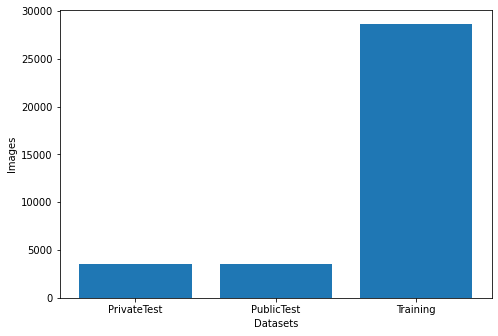

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
datasets = df_usage.index.tolist()
counts = df_usage['emotion'].tolist()
ax.bar(datasets, counts)
plt.xlabel("Datasets")
plt.ylabel("Images")
plt.show()

In [ ]:
train_set = df[df['Usage'] == 'Training']

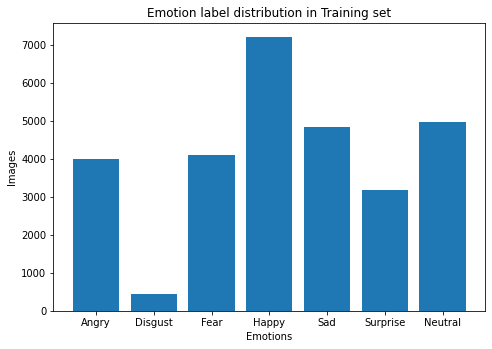

In [22]:
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
image_counts = train_set.groupby(['emotion']).count()['pixels'].tolist()
ax.bar(emotions, image_counts)
plt.xlabel("Emotions")
plt.ylabel("Images")
plt.title("Emotion label distribution in Training set")
plt.show()

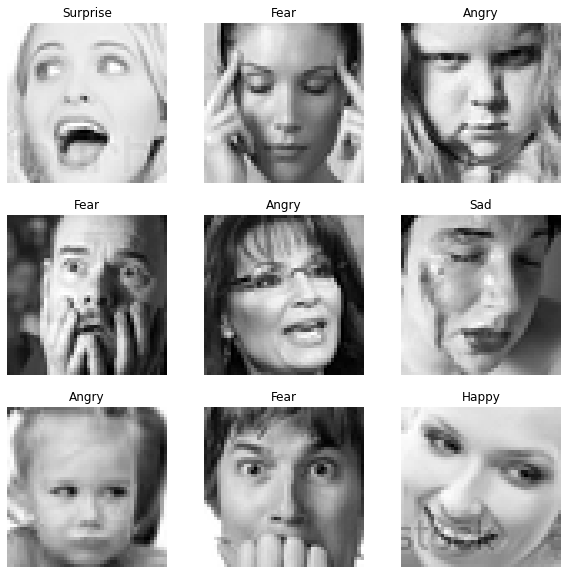

In [26]:
# randomly select 9 images
image_sample = df.sample(9, random_state=5)
 
# Create subplots for images
_, axs = plt.subplots(3, 3, figsize=(10,10))
axs = axs.ravel()
i = 0
for _, row in image_sample.iterrows():
    one_image = np.array([int(pixel) for pixel in row['pixels'].split()]).reshape(48, 48)
    axs[i].imshow(one_image, cmap='gray')
    axs[i].set_title(emotions[row['emotion']])
    axs[i].axis('off')
    i += 1

In [ ]:
def getData(file_name):
    # data consists of 48x48 pixel grayscale images of faces
    # Y will contain the emotion labels
    # X will contain the image pixels
    Y = []
    X = []
    # skip the first line in file
    first = True
    for line in open(file_name):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(pixel) for pixel in row[1].split()])

# scale pixel values to be b/w 0 and 1
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

X, Y = getData("fer2013.csv")

In [ ]:
# keras with tensorflow backend
images, pixels = X.shape
X = X.reshape(images, 48, 48, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
# there are 7 classes of emotions
y_train = (np.arange(7) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(7) == y_test[:, None]).astype(np.float32)

In [ ]:
def model():
    model = Sequential()
    input_shape = (48, 48, 1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

model = model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

In [ ]:
from keras import backend as K
# save model at this location after each epoch
path_model = 'model.h5'
K.tensorflow_backend.clear_session() 
model = model() 
# set the learning rate
K.set_value(model.optimizer.lr, 0.001)
# fit the model
# history
h = model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            # progress bar
            verbose=1, 
            validation_data=(X_test, y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),])

Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 52s 2ms/step - loss: 1.6605 - accuracy: 0.3527 - val_loss: 1.5806 - val_accuracy: 0.4021
Epoch 2/20
32298/32298 [==============================] - 45s 1ms/step - loss: 1.3065 - accuracy: 0.5020 - val_loss: 1.4322 - val_accuracy: 0.4246
Epoch 3/20
32298/32298 [==============================] - 44s 1ms/step - loss: 1.1255 - accuracy: 0.5772 - val_loss: 1.1731 - val_accuracy: 0.5595
Epoch 4/20
32298/32298 [==============================] - 44s 1ms/step - loss: 0.9988 - accuracy: 0.6300 - val_loss: 1.1837 - val_accuracy: 0.5653
Epoch 5/20
32298/32298 [==============================] - 44s 1ms/step - loss: 0.8790 - accuracy: 0.6740 - val_loss: 1.2406 - val_accuracy: 0.5467
Epoch 6/20
32298/32298 [==============================] - 44s 1ms/step - loss: 0.7356 - accuracy: 0.7308 - val_loss: 1.1198 - val_accuracy: 0.5921
Epoch 7/20
32298/32298 [==============================] - 44s 1ms/ste

In [35]:
y_pred = model.predict(X_test)
y_test.shape

(3589, 7)

Text(0.5, 1.0, 'Accuracy Curves')

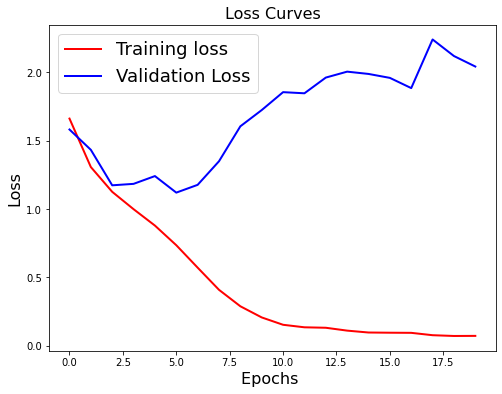

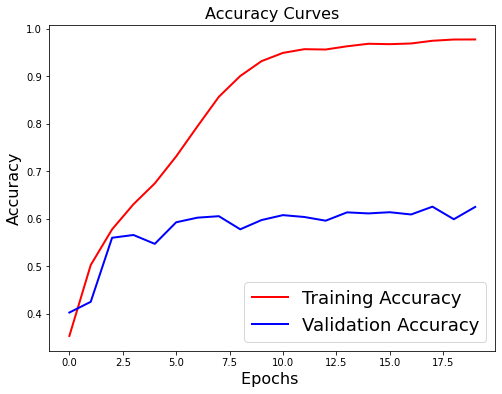

In [21]:
# Loss Curves
plt.figure(figsize = [8,6])
plt.plot(h.history['loss'],'r', linewidth=2.0)
plt.plot(h.history['val_loss'],'b', linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
 
# Accuracy Curves
plt.figure(figsize = [8,6])
plt.plot(h.history['accuracy'],'r', linewidth=2.0)
plt.plot(h.history['val_accuracy'],'b', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

[[267   1  42  23  69   8  74]
 [ 11  30   5   1   4   1   4]
 [ 86   3 227  26  64  37  59]
 [ 55   0  27 728  33  23  54]
 [ 79   1  91  32 292   9  95]
 [ 17   0  27  24   9 347  18]
 [ 42   1  49  49  80  15 350]]


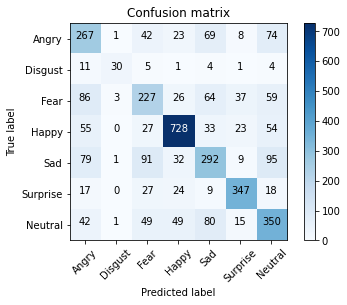

In [49]:
import itertools
from sklearn.metrics import confusion_matrix

y_true = [np.argmax(i) for i in y_test]
y_prediction = [np.argmax(i) for i in y_pred]
cm = confusion_matrix(y_true, y_prediction)
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(7)
plt.xticks(tick_marks, emotions, rotation=45)
plt.yticks(tick_marks, emotions)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()